# Example of XGBoost Usage

## Using XGBoost train

XGBoost train is original function from xgboost to train the model
XGBoost train need the datasets converted into DMatrix format

DMatrix is an internal data structure that is used by XGBoost, which is optimized for both memory efficiency and training speed. You can construct DMatrix from multiple different sources of data.

https://xgboost.readthedocs.io/en/stable/python/python_api.html#:~:text=DMatrix%20is%20an%20internal%20data,PathLike%2Fstring%2Fnumpy.

In [42]:
import xgboost as xgb
from xgboost import XGBRFClassifier as xgbclassifier
from xgboost import DMatrix

import pandas as pd
import numpy as np

from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split

from matplotlib import pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('../data/titanic.csv')
df.head()

,Unnamed: 0,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,0,1,0.0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,1,2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,2,3,1.0,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,3,4,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,4,5,0.0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [9]:
'''
Normally, XGBoost only works with number, for this example
we just exclude text values for simplicity, but we can use encoding or mapping to 
convert text values into number values 
Name, Sex, Ticket, Cabin, Embarked
'''
df = df.loc[:, ~df.columns.isin(['Unnamed: 0', 'PassengerId', 'Name', 'Cabin', 'Ticket'])] #exclude Name, Cabin and Ticket 

'''
mapping categorical into numerical
'''
df.Sex = df.Sex.map({'male': 1, 'female': 0})
df.Embarked = df.Embarked.map({'S': 0, 'C': 1, 'Q': 1})

In [10]:
df.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,0.0,3,1,22.0,1,0,7.2500,0.0
1,1.0,1,0,38.0,1,0,71.2833,1.0
2,1.0,3,0,26.0,0,0,7.9250,0.0
3,1.0,1,0,35.0,1,0,53.1000,0.0
4,0.0,3,1,35.0,0,0,8.0500,0.0


In [11]:
'''
train test split
'''
X = df.drop('Survived', axis='columns')
y = df.Survived
X.fillna(-999, inplace=True)
y.fillna(0, inplace=True)
X_train, X_validation, y_train, y_validation = train_test_split(X, y, 
                                                                train_size=0.75,
                                                                random_state=42)

In [12]:
'''
convert all dataset into DMatrix format

Important: DataFrame.dtypes for data must be int, float, bool or category. 
When categorical type is supplied, DMatrix parameter `enable_categorical` must
be set to `True`
'''
dtrain = DMatrix(data=X_train, label=y_train, enable_categorical=True)
dvalidation = DMatrix(data=X_validation, label=y_validation, enable_categorical=True)

In [23]:
'''
train the model
for binary classification please add 'objective': 'binary:logistic' in the params
'''
params = {'max_depth':2, 'eta':1, 
          'objective':'binary:logistic', 
          'eval_metric': 'logloss'}
model = xgb.train(params, dtrain, num_boost_round=2)

In [28]:
'''
predict
XGBoost train does not have predict_proba function like scikit-learn
but the output from predict is still probability, we can put the threshold 
so that we can have the prediction
'''
predicts = model.predict(dvalidation)
print(predicts[:5])
print(f'ROC-AUC score {roc_auc_score(y_validation, predicts):.3f}')

[0.09974871 0.16020918 0.09974871 0.09974871 0.34502193]
ROC-AUC score 0.778


***

## XGBoost using XGBoost classifier

XGBoost classifier is XGBoost wrapped in scikit-learn so that could be 
easily to use as classifier and to use scikit-learn capabilities

When using XGBoost classifier we dont need to specify the objective='binary:logistic' and enable_categorical=Truen because these are the default in XGBoost classifier

The difference between XGBoost classifier with XGB train is XGBoost classifier does not need to 
convert the dataset into DMatrix format

In [32]:
'''
We use the same pre-processed dataset from task above and skip the
process into train the model.

Pay attention that we use X_train, X_validation, y_train, y_validation instead 
dtrain and dvalidation
'''
params = {'base_score': 0.5, 
          'booster': 'gbtree',
          'max_depth': 3,
          'eval_metric': 'logloss'}
model_classifier = xgbclassifier(**params)
model_classifier.fit(X_train, y_train)

XGBRFClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
                colsample_bytree=1, enable_categorical=False,
                eval_metric='logloss', gamma=0, gpu_id=-1, importance_type=None,
                interaction_constraints='', max_delta_step=0, max_depth=3,
                min_child_weight=1, missing=nan, monotone_constraints='()',
                n_estimators=100, n_jobs=4, num_parallel_tree=100,
                objective='binary:logistic', predictor='auto', random_state=0,
                reg_alpha=0, scale_pos_weight=1, tree_method='exact',
                validate_parameters=1, verbosity=None)

In [41]:
'''
predict proba
'''
predicts_proba = model_classifier.predict_proba(X_validation)
print(predicts_proba[:5])
print(f'ROC-AUC score {roc_auc_score(y_validation, predicts_proba[:, 1]):.3f}') #predict_proba[:, 1] means we only take the class 1 probability

[[0.8375908  0.16240916]
 [0.7568611  0.2431389 ]
 [0.8386097  0.16139033]
 [0.8338431  0.16615687]
 [0.6332153  0.3667847 ]]
ROC-AUC score 0.806


***

## Feature importance

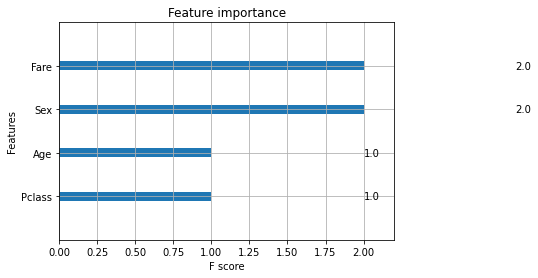

<Figure size 576x576 with 0 Axes>

In [43]:
xgb.plot_importance(model)
plt.figure(figsize=(8, 8))
plt.show()

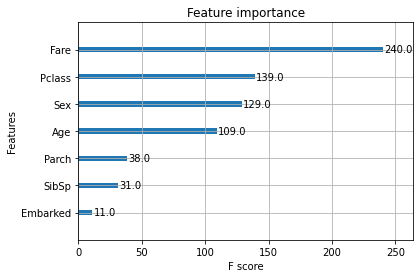

<Figure size 576x576 with 0 Axes>

In [44]:
xgb.plot_importance(model_classifier)
plt.figure(figsize=(8,8))
plt.show()